### 8-1. Seq2seq 기반 한영 번역기 만들기

###### 한국어 폰트 준비 ( NanumBarunGothic )

In [73]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("완료!")

완료!


### 8-2. 데이터 전처리

#### 데이터 준비하기
먼저 프로젝트에 사용될 라이브러리를 import 하도록 합시다.

In [74]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.4.1


In [75]:
# 압축 풀기

'''
! tar -zxvf ~/aiffel/s2s_translation/korean-english-park.dev.tar.gz
! tar -zxvf ~/aiffel/s2s_translation/korean-english-park.test.tar.gz
! tar -zxvf ~/aiffel/s2s_translation/korean-english-park.train.tar.gz
'''

'\n! tar -zxvf ~/aiffel/s2s_translation/korean-english-park.dev.tar.gz\n! tar -zxvf ~/aiffel/s2s_translation/korean-english-park.test.tar.gz\n! tar -zxvf ~/aiffel/s2s_translation/korean-english-park.train.tar.gz\n'

In [76]:
train_folder_path = os.getenv('HOME') + '/aiffel/s2s_translation/train/'
test_folder_path = os.getenv('HOME') + '/aiffel/s2s_translation/test/'

In [77]:
train_ko_data_path = train_folder_path + 'korean-english-park.train.ko'
train_en_data_path = train_folder_path + 'korean-english-park.train.en'

In [78]:
with open(train_ko_data_path, 'r') as f:
    train_ko_data = f.read().splitlines()
    
with open(train_en_data_path, 'r') as f:
    train_en_data = f.read().splitlines()

In [79]:
print('train_ko_data size : ', len(train_ko_data))
print('train_en_data size : ', len(train_en_data))

train_ko_data size :  94123
train_en_data size :  94123


In [80]:
for i in range(0,100,20):
    print('>> ', train_ko_data[i])
    print('>> ', train_en_data[i], '\n')

>>  개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>>  Much of personal computing is about "can you top this?" 

>>  북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>>  Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations. 

>>  "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>>  “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said. 

>>  수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>>  Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project. 

>>  또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
>>  Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of work

###### 중복 데이터 제거

In [81]:
temporal_list = []

for i in range(len(train_ko_data)):
    temporal_list.append(train_ko_data[i]+' \t '+ train_en_data[i])

In [82]:
cleaned_corpus = list(set(temporal_list))
len(cleaned_corpus )

78968

In [83]:
train_ko = []
train_en = []
for i in cleaned_corpus:
    temp = i.split(' \t ')
    train_ko.append(temp[0])
    train_en.append(temp[1])

###### 한국어 문장 분포 확인

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 63


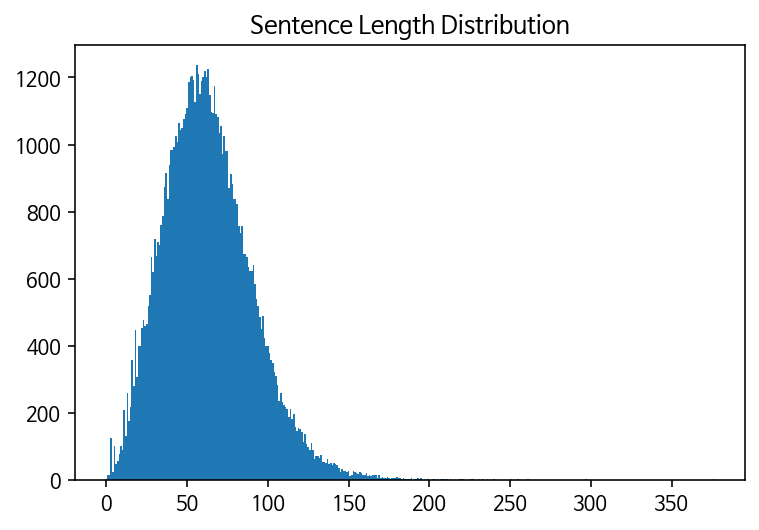

In [84]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_ko:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_ko))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_ko:
    sentence_length[len(sen)-1] += 1 # 문장의 길이 별 개수를 담은 Numpy Array

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

###### 영어 문장 분포 확인

문장의 최단 길이: 1
문장의 최장 길이: 605
문장의 평균 길이: 133


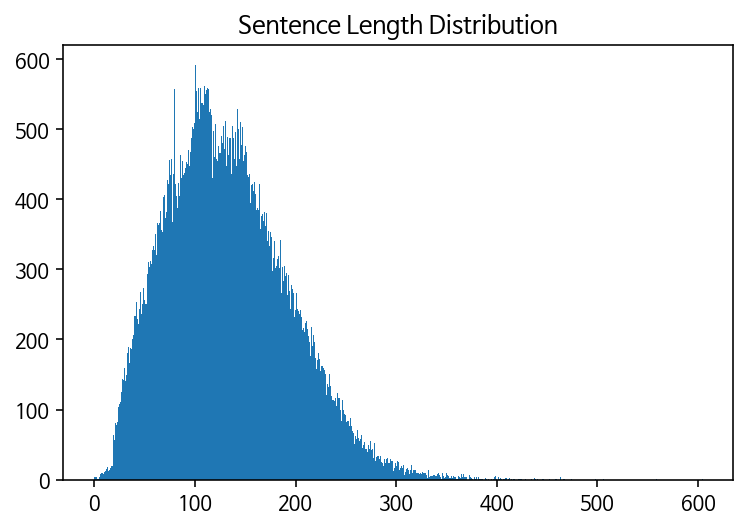

In [85]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_en:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_en))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_en:
    sentence_length[len(sen)-1] += 1 # 문장의 길이 별 개수를 담은 Numpy Array

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

#### 데이터 전처리: 정제하기

In [86]:
#정제는 아래 소스를 실행함으로써 진행할 수 있습니다.

def preprocess_sentence(sentence, s_token=False, e_token=False,lang = 'KOR'):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    if lang == 'KOR' :
        sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
        sentence = sentence.strip()
        
        mecab = Mecab()
        sentence = mecab.morphs(sentence)
        
    elif lang == 'ENG' :
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        if s_token:
            sentence = '<start> ' + sentence
        if e_token:
            sentence += ' <end>'
        sentence = sentence.split()
    return sentence

print("실행")

실행


###### 토큰의 길이가 30 이하인 데이터로 코퍼스 구축

In [87]:
enc_corpus = []
dec_corpus = []

for pair in cleaned_corpus:
    kor, eng = pair.split(" \t ")
    if len(kor.split()) <= 20 & len(eng.split())<= 20: 
        enc_corpus.append(preprocess_sentence(kor, lang = 'KOR'))
        dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True, lang= 'ENG'))

###### 데이터 토큰화

In [88]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000, filters='', oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [89]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

In [90]:
len(enc_tokenizer.index_word), len(enc_tokenizer.index_word)

(30237, 30237)

In [91]:
enc_tensor[0]

array([13939,   868,     7,   329,     4,  8736,   261,     2,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [92]:
dec_tensor[0]

array([    5,  6842, 10238,    10,  1895,    12,  2091,   276,     3,
           6,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

### 8-3. 모델 설계

In [93]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


위 그림과 동일한 구조를 갖는 Encoder 클래스와 Decoder 클래스를 설계하고, 아래 소스를 실행해 답안과 같은 결과를 얻으세요.

In [94]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [95]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [96]:
# 코드를 실행하세요.

BATCH_SIZE     = 128
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (128, 30, 512)
Decoder Output: (128, 31843)
Decoder Hidden State: (128, 512)
Attention: (128, 30, 1)


### 8-4. 훈련하기 (1) Optimizer & Loss

#### Optimizer & Loss

In [97]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # 0인 경우,False, 0이 아닌 경우, True 
    loss = loss_object(real, pred) # ???
    
    mask = tf.cast(mask, dtype=loss.dtype) # loss와 동일한 데이터타입으로 변환
    loss *= mask # loss에 mask를 더해주는 것의 의미는?
    
    return tf.reduce_mean(loss) # axis가 따로 설정 안되어있다면, None이고, 이는 모든 차원을 축소시킨다. 
                                 # tf.reduce_mean을 사용할때는 dtype을 유의하도록 하자 
print("완료")

완료


### 8-5. 훈련하기 (2) train_step 구현하기

train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수입니다.

In [98]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### 8-6. 훈련하기 (3) 훈련 시작하기

In [99]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 20: 100%|██████████| 273/273 [08:17<00:00,  1.82s/it, Loss 2.3185]


In [113]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input: ['미국', '과', '중국', '사이', '에', '전쟁', '이', '벌어졌', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


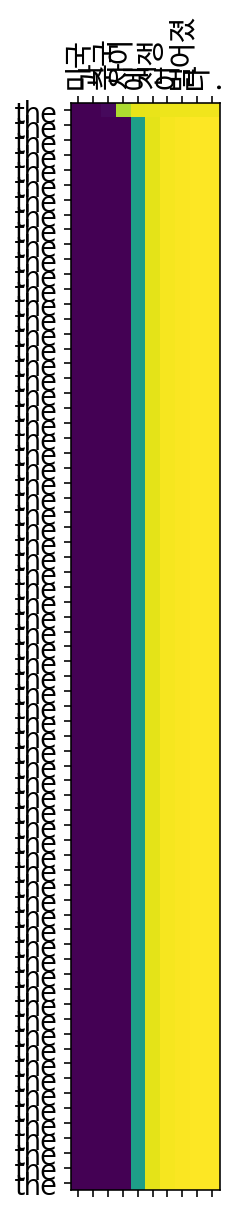

In [115]:
translate("미국과 중국 사이에 전쟁이 벌어졌다.", encoder, decoder)

Input: ['경호', '로보트', '가', '화재', '를', '막', '기', '위해', '사용', '되', '고', '있', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


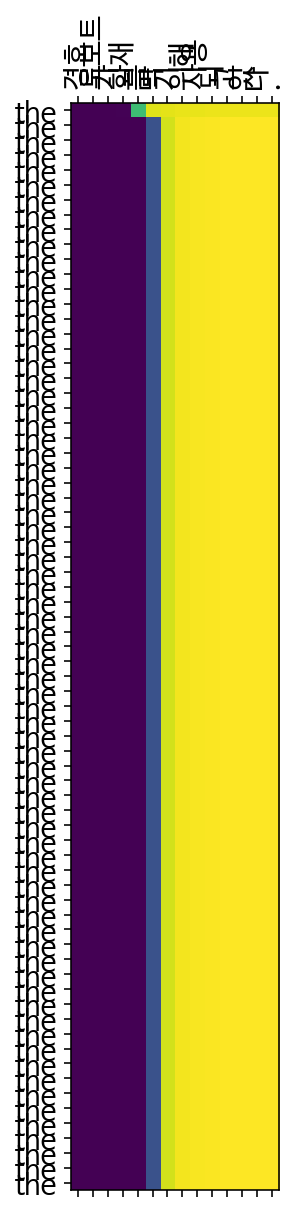

In [116]:
translate("경호 로보트가 화재를 막기 위해 사용되고 있다.", encoder, decoder)

#### 회고록

결과가 좋지 못하다. 
여러 하이퍼파라미터 튜닝을 시도해보고 싶었지만, resource 관련된 error로 인해, 하이퍼 파라미터 튜닝이라기보다는 weight의 개수를 줄이는 시도를 했던 것 같다. 컴퓨팅 능력의 필요성과 컴퓨팅을 효율적으로 하기 위한 알고리즘의 필요성을 더욱 느낀 하루다